In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
!nvidia-smi

Fri May  8 08:46:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [4]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [0]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # randomly apply transformation (color distortions and blur) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)
        sample = self._random_apply(self._gaussian_blur, sample, p=0.5)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x

    def _gaussian_blur(self, image, sigma=tf.random.uniform([], 0.1, 2.0, dtype=tf.float32),
                       padding='SAME'):
        kernel_size = image.shape[1]
        radius = tf.cast(kernel_size / 2, dtype=tf.int32)
        kernel_size = radius * 2 + 1
        
        x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
        blur_filter = tf.exp(
          -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
        blur_filter /= tf.reduce_sum(blur_filter)
        
        # One vertical and one horizontal filter.
        blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
        blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
        num_channels = tf.shape(image)[-1]
        blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
        blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
        
        expand_batch_dim = image.shape.ndims == 3
        if expand_batch_dim:
            # Tensorflow requires batched input to convolutions, which we can fake with
            # an extra dimension.
            image = tf.expand_dims(image, axis=0)
        
        blurred = tf.nn.depthwise_conv2d(
            image, blur_h, strides=[1, 1, 1, 1], padding=padding)
        blurred = tf.nn.depthwise_conv2d(
            blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
        
        if expand_batch_dim:
            blurred = tf.squeeze(blurred, axis=0)
        
        blurred = tf.clip_by_value(blurred, 0., 1.)
        return blurred
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [0]:
data_augmentation = Sequential([Lambda(CustomAugment())])

In [0]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [0]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

In [0]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

In [0]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [0]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [0]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        # tf.summary.histogram('zis', zis, step=optimizer.iterations)
        # tf.summary.histogram('zjs', zjs, step=optimizer.iterations)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature
        # assert l_pos.shape == (config['batch_size'], 1), "l_pos shape not valid" + str(l_pos.shape)  # [N,1]

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            # assert l_neg.shape == (
            #     config['batch_size'], 2 * (config['batch_size'] - 1)), "Shape of negatives not expected." + str(
            #     l_neg.shape)
            logits = tf.concat([l_pos, l_neg], axis=1)  # [N,K+1]
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [0]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

  1%|          | 1/100 [00:29<48:08, 29.18s/it]

epoch: 1 loss: 4.678


 11%|█         | 11/100 [03:10<23:43, 15.99s/it]

epoch: 11 loss: 3.398


 21%|██        | 21/100 [05:43<20:16, 15.40s/it]

epoch: 21 loss: 2.808


 31%|███       | 31/100 [08:16<17:39, 15.36s/it]

epoch: 31 loss: 2.448


 41%|████      | 41/100 [10:49<15:04, 15.33s/it]

epoch: 41 loss: 2.160


 51%|█████     | 51/100 [13:22<12:31, 15.33s/it]

epoch: 51 loss: 1.954


 61%|██████    | 61/100 [15:55<09:54, 15.25s/it]

epoch: 61 loss: 1.819


 71%|███████   | 71/100 [18:29<07:26, 15.41s/it]

epoch: 71 loss: 1.729


 81%|████████  | 81/100 [21:02<04:50, 15.29s/it]

epoch: 81 loss: 1.640


 91%|█████████ | 91/100 [23:35<02:17, 15.32s/it]

epoch: 91 loss: 1.559


100%|██████████| 100/100 [25:52<00:00, 15.53s/it]


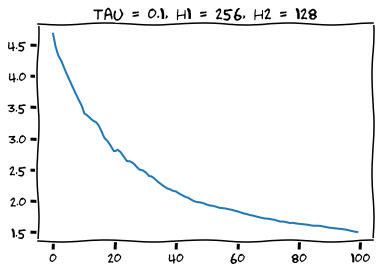

In [14]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=100)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128")
    plt.show()

In [15]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [0]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"

In [17]:
filename

'20200508-091658resnet_simclr.h5'

In [18]:
!gsutil mb gs://resnet_simclr_imagenet
resnet_simclr.save_weights(filename)
!gsutil -m cp 20200508-091658resnet_simclr.h5 gs://resnet_simclr_imagenet/

Creating gs://resnet_simclr_imagenet/...
Copying file://20200508-091658resnet_simclr.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/92.3 MiB.                                     
